# Outwasher

### This notebook allows you to run the Outwasher Class to simulate bay-to-ocean flows and sediment fluxes. 

In [1]:
import numpy as np
import math
import os
# import imageio
from barrier3d import Barrier3d
from cascade.outwasher_reorganized import Outwasher
from cascade.outwasher_reorganized import (plot_ElevAnimation, plot_DischargeAnimation, plot_SlopeAnimation, 
plot_Qs2Animation, plot_SedOutAnimation, plot_SedInAnimation)
import matplotlib.pyplot as plt
import imageio
import csv

Here we are importing the bay level data and manipulating it to our liking. This includes converting the data from m MSL to dam MHW. We then increase the values by 0.05 dam so that they are more significant. However, we also give the bay a max elevation of 0.220 dam, so that water levels never overtop the entire dune system. 

In [2]:
with open(r"C:\Users\Lexi\Documents\Research\Outwasher\chris stuff\sound_data.txt", newline='') as csvfile:
    sound_data = list(csv.reader(csvfile))[0]
sound_data = [float(s) / 10 - 0.054 for s in sound_data]  # [dam MHW] Chris' sound elevations were in m MSL,
# so converted to NAVD88 then MHW and dam
sound_data = [s + 0.05 for s in sound_data]  # [dam MHW] just increasing the values
# setting all negative values to 0
sound_data = sound_data[20:]
for index, value in enumerate(sound_data):
    #     # smaller used 0.05
    if value > 0.220:
        sound_data[index] = 0.220
sound_data[0] = 0

#### Next, we run Barrier3D for a time step so that we have the input variables we need for Outwasher. Then we call Outwasher.
<div class="alert alert-block alert-info"><b>Configuration:</b> Substep = 2, Cx = 10, Ki = 7.5x10$^{-3}$.</div>

<div class="alert alert-block alert-danger">Make sure to change the runID, substep, Cx, and Ki values (below) if re-running different configurations. AND RESET the storm series (included now)</div>

In [3]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep2"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]

outwash = Outwasher(b3d, runID, path, substep=2, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
The sediment volume lost in storm 1 was 3.429 dam^3
The total sediment volume lost was 3.429 dam^3


#### The rest of the code is making figures. 

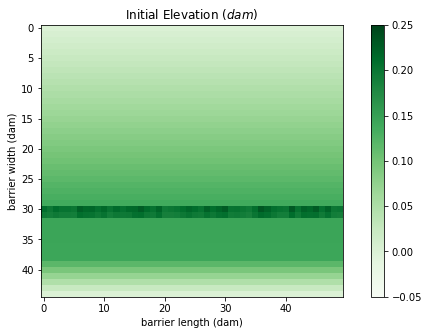

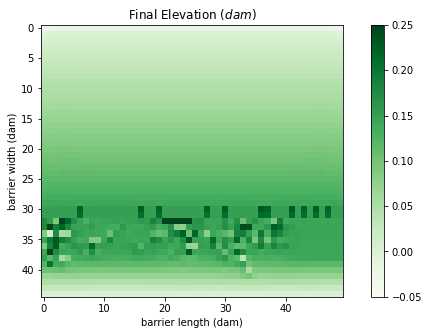

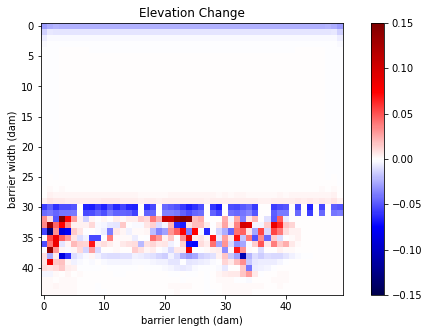

In [4]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

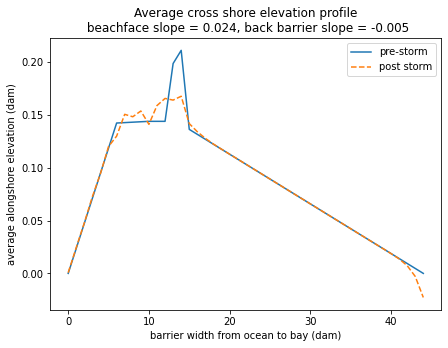

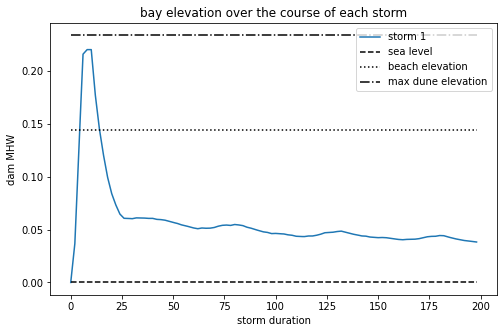

In [5]:
plt.rcParams['figure.figsize'] = (7,5)

# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(outwash._m_beachface, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()

In [6]:
# # plotting sound level WRT cross-sectionally averaged domain
# fig6 = plt.figure()
# ax6 = fig6.add_subplot(111)
# ax6.plot(cross_section)
# x = len(cross_section)
# for index, value in enumerate(storm_series[1]):
#     if index < 12:
#         ax6.plot(range(x), np.ones(x) * value, linestyle="dashed", label="TS = {0}".format(index))
# ax6.set_title("sound level for first 12 TS")
# ax6.legend()
# ax6.set_ylabel("Elevation (dam)")
# ax6.set_xlabel("Cross-shore Distance from Bay to Ocean (dam)")
# plt.savefig(newpath + "baylevels")

In [7]:
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)

[ * elevation GIF successfully generated * ]

[ * discharge GIF successfully generated * ]

[ * slope GIF successfully generated * ]

[ * SedOut GIF successfully generated * ]

[ * SedIn GIF successfully generated * ]


<div class="alert alert-block alert-info"><b>Configuration:</b> Substep = 3, Cx = 10, Ki = 7.5x10$^{-3}$.</div>

In [8]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep3"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]

outwash = Outwasher(b3d, runID, path, substep=3, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

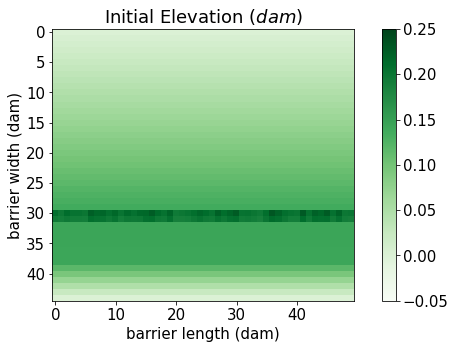

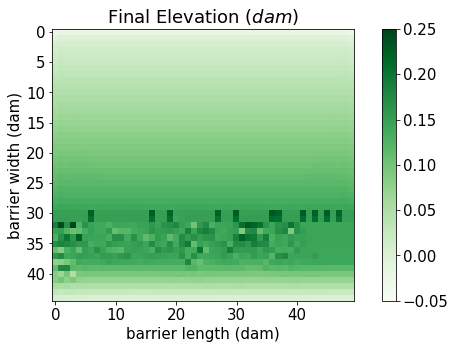

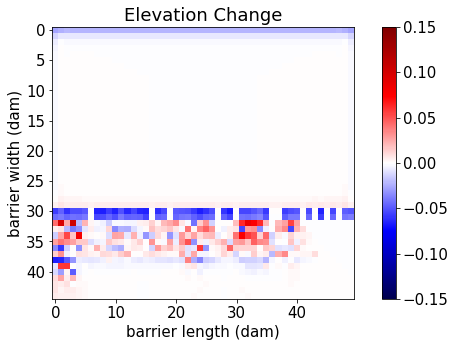

In [9]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

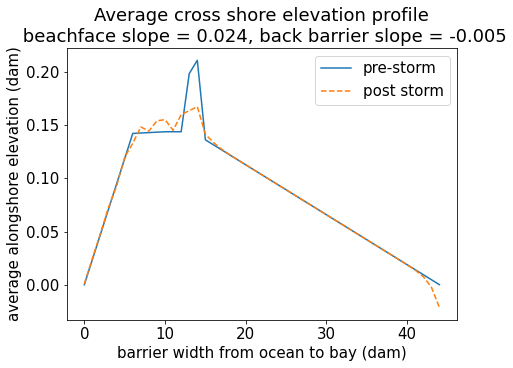

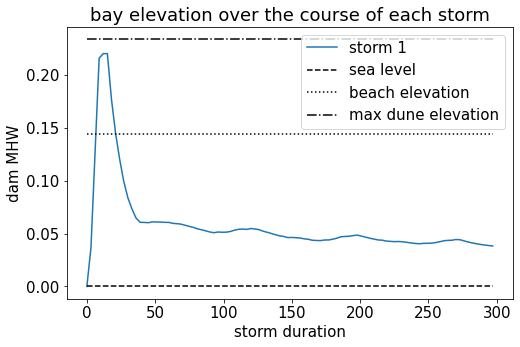

In [10]:
plt.rcParams['figure.figsize'] = (7,5)

# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(outwash._m_beachface, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()

In [11]:
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)

[ * elevation GIF successfully generated * ]

[ * discharge GIF successfully generated * ]

[ * slope GIF successfully generated * ]

[ * SedOut GIF successfully generated * ]

[ * SedIn GIF successfully generated * ]


<div class="alert alert-block alert-info"><b>Configuration:</b> Substep = 4, Cx = 10, Ki = 7.5x10$^{-3}$.</div>

In [12]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep4"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]

outwash = Outwasher(b3d, runID, path, substep=4, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

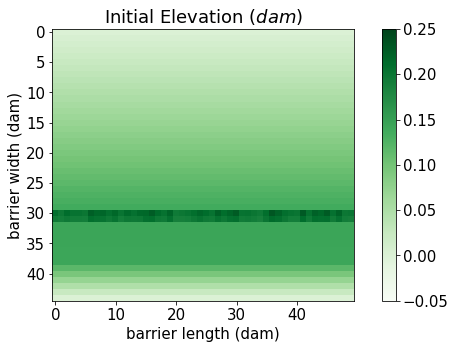

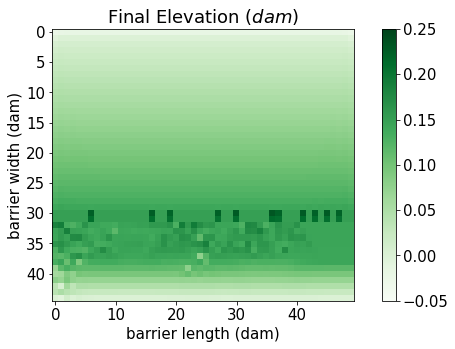

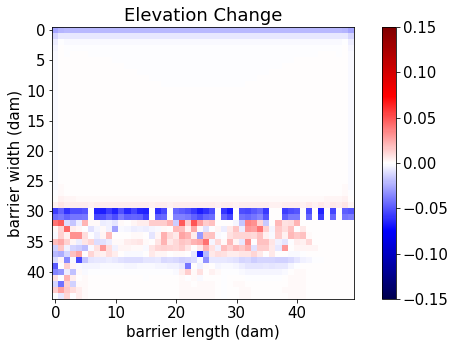

In [13]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.05, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

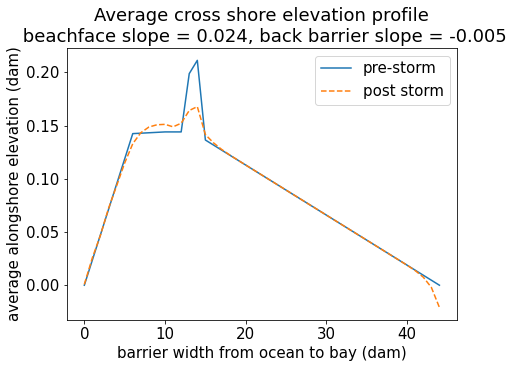

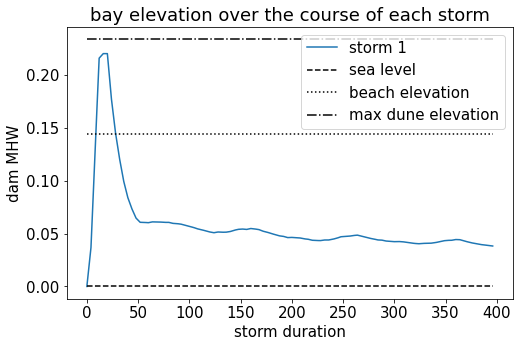

In [14]:
plt.rcParams['figure.figsize'] = (7,5)

# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(outwash._m_beachface, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()

In [15]:
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)

[ * elevation GIF successfully generated * ]

[ * discharge GIF successfully generated * ]

[ * slope GIF successfully generated * ]

[ * SedOut GIF successfully generated * ]

[ * SedIn GIF successfully generated * ]


<div class="alert alert-block alert-warning"><b>Configuration:</b> Substep = 2, Cx = 10, Ki = 7.5x10$^{-3}$. Changed the beach slope to be steeper.</div>

In [3]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep2_mbeach024"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]
m_beach = 0.024

outwash = Outwasher(b3d, runID, path, substep=2, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d, m_beach)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
The sediment volume lost in storm 1 was 3.926 dam^3
The total sediment volume lost was 3.926 dam^3


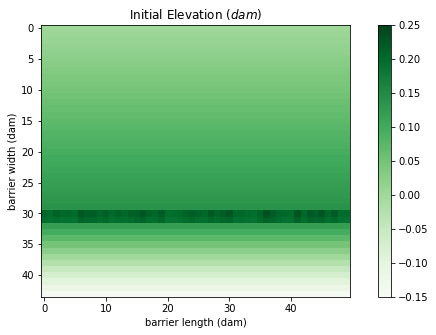

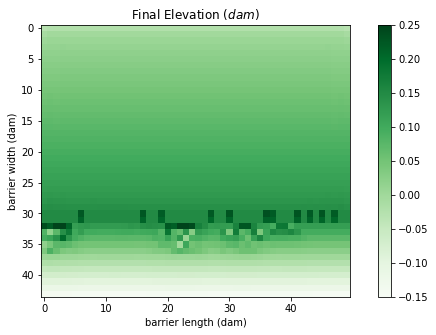

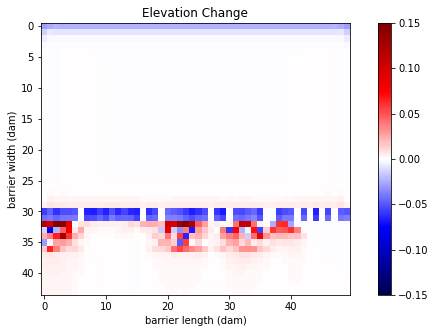

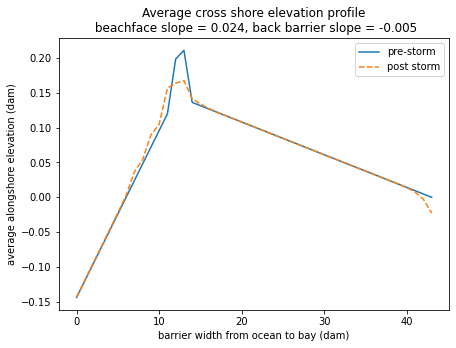

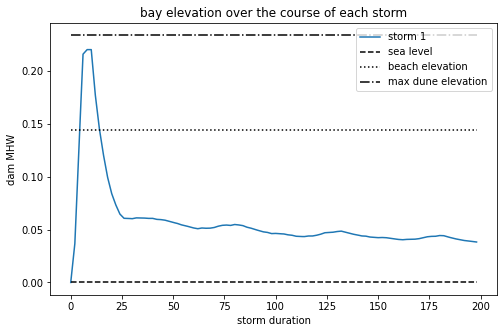

[ * elevation GIF successfully generated * ]

[ * discharge GIF successfully generated * ]

[ * slope GIF successfully generated * ]

[ * SedOut GIF successfully generated * ]

[ * SedIn GIF successfully generated * ]


In [4]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

### ELEVATION PLOTS-------------------------------------------------------------------------------------------------------------
# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

plt.rcParams['figure.figsize'] = (7,5)


### AVERAGE ELEVATION PLOT------------------------------------------------------------------------------------------------------
# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(m_beach, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

### HYDROGRAPH------------------------------------------------------------------------------------------------------------------
# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()
    
### GIFS------------------------------------------------------------------------------------------------------------------------
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)

<div class="alert alert-block alert-warning"><b>Configuration:</b> Substep = 3, Cx = 10, Ki = 7.5x10$^{-3}$. Changed the beach slope to be steeper.</div>

In [6]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep3_mbeach024"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]
m_beach = 0.024

outwash = Outwasher(b3d, runID, path, substep=3, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d, m_beach)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

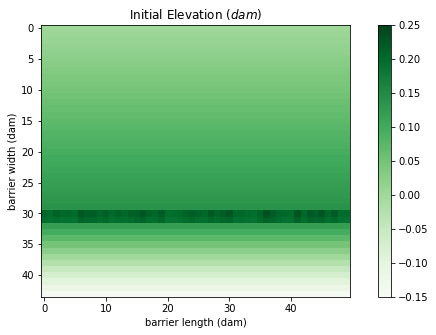

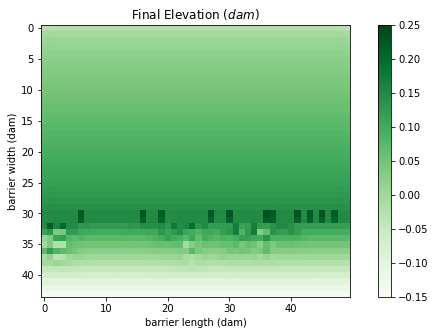

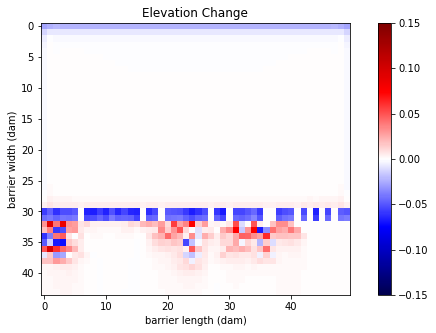

In [7]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

### ELEVATION PLOTS-------------------------------------------------------------------------------------------------------------
# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

plt.rcParams['figure.figsize'] = (7,5)


### AVERAGE ELEVATION PLOT------------------------------------------------------------------------------------------------------
# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(m_beach, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

### HYDROGRAPH------------------------------------------------------------------------------------------------------------------
# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()
    
### GIFS------------------------------------------------------------------------------------------------------------------------
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)

<div class="alert alert-block alert-warning"><b>Configuration:</b> Substep = 4, Cx = 10, Ki = 7.5x10$^{-3}$. Changed the beach slope to be steeper.</div>

In [9]:
b3d = Barrier3d.from_yaml("C:/Users/Lexi/PycharmProjects/Barrier3d/tests/test_params/")
b3d.update()
b3d.update_dune_domain()

path = "C:/Users/Lexi/Documents/Research/Outwasher/Output/edgesedited_bay220limited/"
runID = "dynamic_discharge_AVG_FACTOR15_Kie-3_substep4_mbeach024"
newpath = path + runID + "/"
# storm series is year the storm occured, the bay elevation for every time step, and the duration of the storm
storm_series = [1, sound_data, len(sound_data)]
m_beach = 0.024

outwash = Outwasher(b3d, runID, path, substep=4, Cx=10, Ki=7.5E-3,)
discharge, elev_change, domain, qs_lost, slopes2, dictionary, qs2, storm_data, sedout, sedin, domain_array, OW_TS \
    = outwash.update(storm_series, b3d, m_beach)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

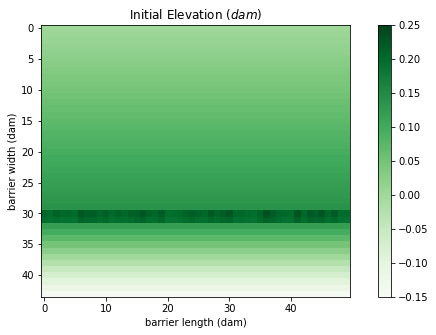

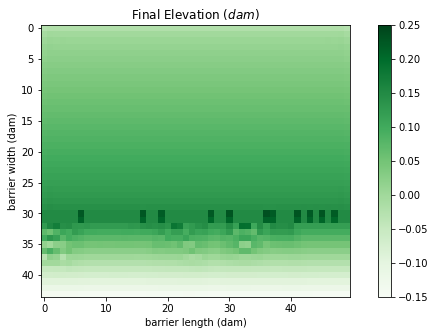

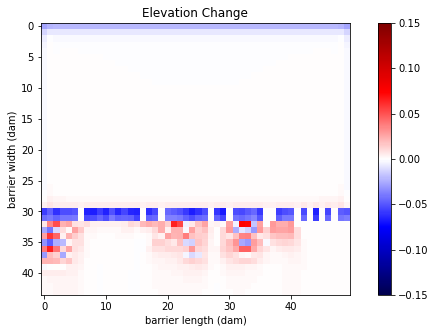

In [10]:
initial_domain = domain_array[0]
final_domain = domain_array[1]

plt.rcParams['figure.figsize'] = (10,5)

### ELEVATION PLOTS-------------------------------------------------------------------------------------------------------------
# plotting initial domain
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# fig1, (ax1, ax3) = plt.subplots(1, 2, sharey=True)
mat = ax1.matshow(
    initial_domain,
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
fig1.colorbar(mat)
ax1.set_title("Initial Elevation $(dam)$")
ax1.set_ylabel("barrier width (dam)")
ax1.set_xlabel("barrier length (dam)")
plt.gca().xaxis.tick_bottom()
fig1.savefig(newpath + "0_domain", facecolor='w')

# plotting post storm elevation
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
mat2 = ax2.matshow(
    final_domain[:, :],
    cmap="Greens",
    vmin=-0.15, vmax=0.25,
)
ax2.set_xlabel('barrier length (dam)')
ax2.set_ylabel('barrier width (dam)')
# ax2.set_title("Elevation after storm {0} $(dam)$".format(n + 1))
ax2.set_title("Final Elevation $(dam)$")
plt.gca().xaxis.tick_bottom()
fig2.colorbar(mat2)
fig2.savefig(newpath + "final_domain", facecolor='w')

# plotting domain elevation change
domain_change = final_domain - initial_domain
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
mat3 = ax3.matshow(
    domain_change,
    # origin="upper",
    cmap="seismic",
    vmin=-0.15, vmax=0.15,
)
ax3.set_xlabel('barrier length (dam)')
ax3.set_ylabel('barrier width (dam)')
ax3.set_title("Elevation Change")
plt.gca().xaxis.tick_bottom()
fig3.colorbar(mat3)
fig3.savefig(newpath + "elev_change_domain", facecolor='w')

plt.rcParams['figure.figsize'] = (7,5)


### AVERAGE ELEVATION PLOT------------------------------------------------------------------------------------------------------
# plotting pre-storm cross section for row 21 (a gap where overwash occurs)
cross_section = np.mean(initial_domain, 1)
cross_section = np.flip(cross_section)
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(range(len(initial_domain)), cross_section, label="pre-storm")


# plotting post-storm cross section
cross_section2 = np.mean(final_domain, 1)
cross_section2 = np.flip(cross_section2)
ax4.plot(range(len(final_domain)), cross_section2, label="post storm", linestyle="dashed")
# dune_gap_el = np.flip(full_domain[:, 21])
# ax4.plot(range(len(full_domain)), dune_gap_el, label="dune gap (21) post", linestyle="dashed")
ax4.set_xlabel("barrier width from ocean to bay (dam)")
ax4.set_ylabel("average alongshore elevation (dam)")
# ax4.set_title("Cross shore elevation profile for col 21\n "
#               "beachface slope = {0}, back barrier slope = {1}".format(round(m_beachface, 3), round(Si, 3)))
ax4.set_title("Average cross shore elevation profile\n "
              "beachface slope = {0}, back barrier slope = {1}".format(round(m_beach, 3),
                                                                       round(outwash._Si, 3)))
ax4.legend()
plt.show()
# plt.savefig(newpath + "cross_shore_21")
fig4.savefig(newpath + "avg_cross_shore", facecolor='w')

### HYDROGRAPH------------------------------------------------------------------------------------------------------------------
# plot the bay elevation throughout each storm with sea level and beach elevation references
plt.rcParams['figure.figsize'] = (8,5)

numstorm = storm_series[0]
x = range(0, storm_series[2])
sea_level_line = outwash._sea_level * np.ones(len(x))
beach_elev_line = outwash._beach_elev * np.ones(len(x))
dune_elev_line = max(outwash._dune_crest + outwash._berm_el) * np.ones(len(x))

for n in range(numstorm):
    fig5 = plt.figure()
    ax5 = fig5.add_subplot(111)
    ax5.plot(x, storm_series[1], label='storm {0}'.format(n + 1))
    # if we have multiple storms, will only need to plot these once
    ax5.plot(x, sea_level_line, 'k', linestyle='dashed', label='sea level')
    ax5.plot(x, beach_elev_line, 'k', linestyle='dotted', label='beach elevation')
    ax5.plot(x, dune_elev_line, 'k', linestyle='dashdot', label='max dune elevation')
    ax5.set_xlabel("storm duration")
    ax5.set_ylabel("dam MHW")
    ax5.set_title("bay elevation over the course of each storm")
    ax5.legend()
    plt.show()
    fig5.savefig(newpath + "hydrograph", facecolor='w')
    plt.close()
    
### GIFS------------------------------------------------------------------------------------------------------------------------
# change if substep is 2
# TMAX = storm_series[2]
# TMAX = 2*storm_series[2]
start = OW_TS[0]
stop = OW_TS[-1]
dir = newpath
plot_ElevAnimation(elev_change, dir, start, stop)
plot_DischargeAnimation(discharge, dir, start, stop)
plot_SlopeAnimation(slopes2, dir, start, stop)
# plot_Qs2Animation(qs2, dir, TMAX)
plot_SedOutAnimation(sedout, dir, start, stop)
plot_SedInAnimation(sedin, dir, start, stop)
# time_step = [0]
# plot_ModelTransects(b3d, time_step)